**PARTE 1**


# **Instalação e import das dependências**

In [ ]:
!pip install mysql.connector
!pip install boto3
!pip install totalvoice

     |████████████████████████████████| 11.9MB 311kB/s 
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp37-cp37m-linux_x86_64.whl size=247965 sha256=d3030c5cf533d1033c9b05e76ca6e37b4575a3e8e563b7f018357f206fe5cee2
  Stored in directory: /root/.cache/pip/wheels/8c/83/a1/f8b6d4bb1bd6208bbde1608bbfa7557504bed9eaf2ecf8c175
Successfully built mysql.connector
     |████████████████████████████████| 133kB 4.2MB/s 
     |████████████████████████████████| 81kB 7.2MB/s 
     |████████████████████████████████| 7.6MB 15.0MB/s 
     |████████████████████████████████| 143kB 33.2MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import json
import boto3
import getpass
import requests
import mysql.connector
import matplotlib.pyplot as plt

from time import sleep
from datetime import date, timedelta
from botocore.exceptions import ClientError

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
#Endpoints
url1 = "https://api.covid19api.com/countries"
url2 = "https://api.covid19api.com/country/"
#Script de insert ao banco RDS
stm1 = 'INSERT INTO gama.countries (Country,Slug,ISO2)  VALUES (%s,%s,%s)'
stm2 = 'INSERT INTO gama.countryData (ID, CountryCode,Province, City, CityCode, Lat, Lon, Confirmed, Deaths, Recovered, Active,Date) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)'
stm3 = 'INSERT INTO gama.provinceData (ID, CountryCode,Province, City, CityCode, Lat, Lon, Confirmed, Deaths, Recovered, Active,Date) VALUES (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)'

# **Carga da api para arquivo local**

In [ ]:
#Envia o request para obter lista de Paises
response1 = requests.get(url1).json() 

#Salva o JSON em arquivo
a = json.dumps(response1)

f = open("countries.json", "wt")
f.write(a)
f.close()

In [ ]:
#open and read the file after the appending:
f = open("countries.json", "r")
file = f.read()
file = json.loads(file)

In [ ]:
%time
DAY = timedelta(7)
dataB = date.today()
dataA = dataB - DAY
DAY = timedelta(8)

#Percorre endpoints e gera lista
dados = []
tam = len(file)
for value1 in file: #Percorre o dicionario dos Paises para obter informaões de um em um
   if (value1['Slug'] != 'united-states'):
      print(str(tam) + ' - ' + value1['Slug'])
      try:
          sleep(1)
          response2 = requests.get(url2 + value1['Slug']) #request em cada enpoint dos Paises
          response2 = response2.json()
          dados.append(response2)
      except:
          print('Falha no request')
   else:
      print(str(tam) + ' - ' + value1['Slug'])
      while(dataB >= date.fromisoformat('2020-01-22')):
          response2 = requests.get('https://api.covid19api.com/country/united-states?from='+str(dataA)+'&to='+str(dataB)) #request a cada 7 dias
          response2 = response2.json()
          sleep(1)
          dados.append(response2)
          dataB = dataB - DAY
          dataA = dataA - DAY
   tam -= 1

In [ ]:
#Salva arquivo de dados dos paises 
a = json.dumps(dados)
f = open("countryData.json", "wt")
f.write(a)
f.close()

# *ATUALIZA BASE COM DADOS ATUALIZADOS*





In [ ]:
#Envia o request para obter lista de Paises
file = requests.get(url1).json() 

%time
DAY = timedelta(1)
dataB = date.today()
dataA = dataB - DAY

#Percorre endpoints e gera lista
dados = []
tam = len(file)
for value1 in file: #Percorre o dicionario dos Paises para obter informaões de um em um
    print(str(tam) + ' - ' + value1['Slug'])
    try:
        sleep(1)
        response2 = requests.get('https://api.covid19api.com/country/'+value1['Slug']+'?from='+str(dataA)+'&to='+str(dataB)) #request em cada enpoint dos Paises
        response2 = response2.json()
        dados.append(response2)
    except:
        print('Falha no request')
    tam -= 1

    

In [ ]:
for x in dados:
  print(x)

# **Faz Upload e Download do arquivo para o S3**

In [ ]:
#Cria client do boto para conexao com o S3
s3 = boto3.client('s3',
                  aws_access_key_id='',
                  aws_secret_access_key='')

In [ ]:
#UPLOAD do arquivo para o repositorio S3
with open("countries.json", "rb") as f:
    s3.upload_fileobj(f, "gamabk", "countries.json")
f.close()

with open("countryData.json", "rb") as f:
    s3.upload_fileobj(f, "gamabk", "countryData.json")
f.close()

In [ ]:
#DOWNLOAD do arquivo do repositório S3
with open('countries.json', 'wb') as f:
    s3.download_fileobj('gamabk', 'countries.json', f)
f.close()

with open('countryData.json', 'wb') as f:
    s3.download_fileobj('gamabk', 'countryData.json', f)
f.close()

# **Conexão com MySql, Script de Criação das tabelas**

In [ ]:
#Conexão com o banco de dados da RDS
con = mysql.connector.connect(
  host="adlimnow.ctik6gdtgtll.us-east-2.rds.amazonaws.com",
  user="admin",
  password=getpass.getpass('Senha: '),
  database="gama"
)

mycursor = con.cursor()

Senha: ··········


In [ ]:
try: #script de criar tabela countries no banco
    mycursor.execute("CREATE TABLE countries \
    (Country VARCHAR(50), \
    Slug VARCHAR(50), \
    ISO2 VARCHAR(2), \
    PRIMARY KEY (`ISO2`))")
except Exception as error:
    print(error)

try: #script de criar tabela countryData no banco
    mycursor.execute("CREATE TABLE countryData \
    (ID VARCHAR(50),\
    CountryCode VARCHAR(2), \
    Province VARCHAR(100), \
    City VARCHAR(100), \
    CityCode VARCHAR(50), \
    Lat VARCHAR(10), \
    Lon VARCHAR(10), \
    Confirmed INTEGER, \
    Deaths INTEGER, \
    Recovered INTEGER, \
    Active INTEGER, \
    Date DATETIME, \
    PRIMARY KEY (`ID`), \
    FOREIGN KEY (CountryCode) REFERENCES countries(ISO2))")
except Exception as error:
    print(error)

try: #script de criar tabela provinceData no banco
    mycursor.execute("CREATE TABLE provinceData \
    (ID VARCHAR(50), \
    CountryCode VARCHAR(2), \
    Province VARCHAR(100), \
    City VARCHAR(100), \
    CityCode VARCHAR(50), \
    Lat VARCHAR(10), \
    Lon VARCHAR(10), \
    Confirmed INTEGER, \
    Deaths INTEGER, \
    Recovered INTEGER, \
    Active INTEGER, \
    Date DATETIME, \
    PRIMARY KEY (`ID`), \
    FOREIGN KEY (CountryCode) REFERENCES countries(ISO2)) ")
except Exception as error:
    print(error)

# **Abre o arquivo e insere no banco e insere no banco de dados RDS**

In [ ]:
#open and read the file after the appending:
f = open("countries.json", "r")
file1 = f.read()
file1 = json.loads(file1)

#open and read the file after the appending:
f = open("countryData.json", "r")
file2 = f.read()
file2 = json.loads(file2)

f.close()

In [ ]:
#Gerar estrutura dos parametros para insert - Countries
param = []
for value in file1:
  param.append(list(value.values()))

In [ ]:
# Faz o insert na tabela Countries
try:
  mycursor.executemany(stm1, param)
  con.commit()
except Exception as error:
  con.rollback()
  print(error)

In [ ]:
# Faz o insert na tabela CountryData e ProvinceData
def insertDatabase(file2):
  co, pr = [], []
  for value in file2:
    if (len(value) != 2):
      for x in value:
        if (x['Province'] == ''): 
          co.append([x['ID'],x['CountryCode'], x['Province'], x['City'], x['CityCode'], x['Lat'], x['Lon'],x['Confirmed'],x['Deaths'],x['Recovered'],x['Active'],x['Date']])
        else:
          pr.append([x['ID'],x['CountryCode'], x['Province'], x['City'], x['CityCode'], x['Lat'], x['Lon'],x['Confirmed'],x['Deaths'],x['Recovered'],x['Active'],x['Date']])
      try:
        mycursor.executemany(stm2, co)
        con.commit()
        co = []
      except Exception as error:
        print(".",end="")
      try:
        mycursor.executemany(stm3, pr)
        con.commit()
        pr = []
      except Exception as error:
        print(".",end="")
  con.reconnect()

In [ ]:
insertDatabase(file2)

# **Relatórios**

In [ ]:
#deixar variavel em branco para pular envio de sms e TTS
numero_destino = ''

In [ ]:
#API DE VOZ E SMS
from totalvoice.cliente import Cliente

clienteSms = Cliente("3274fd0c31b08177d5e5bbb93b0c9b2d", 'https://api2.totalvoice.com.br/sms') 
clienteTts = Cliente("3274fd0c31b08177d5e5bbb93b0c9b2d", 'https://api2.totalvoice.com.br/tts') 
numero_destino = getpass.getpass('Digite o numero de telefone com DDD: ')
resposta_usuario = True
detecta_caixa = True

Digite o numero de telefone com DDD: ··········


In [ ]:
#CONSULTA SUMÁRIO DE PAÍS
pais = input('País: ')

mycursor.execute('''select co.Country, cd1.Confirmed, cd1.Deaths, cd1.Recovered, cd1.Active, cd1.Date, 
(cd1.Confirmed - cd2.Confirmed) as day_confirmed,  
(cd1.Deaths - cd2.Deaths) as day_deaths,  
(cd1.Recovered - cd2.Recovered) as day_recovered 
from countryData cd1 
left join 
(select CountryCode, Confirmed, Deaths, Recovered, Active, Date from countryData) cd2  
on cd1.CountryCode = cd2.CountryCode and 
cd1.Date = (cd2.Date + interval 1 DAY) 
left join countries co 
on co.ISO2 = cd1.CountryCode 
where co.Country = "''' + pais + '''" and  
cd2.CountryCode is not null 
order by cd1.Date desc''') 

dados = mycursor.fetchall()

if (len(dados) != 0):
  print('Linhas retornadas: '+ str(len(dados)))
else:
  print('Linhas retornada: '+ str(len(dados)))

País: Brazil
Linhas retornadas: 508


Parnorama diário - Brazil
Quantidade de casos do dia - 2021-06-13: 37948
Quantidade de mortes do dia - 2021-06-13: 1129

Evolução de casos confirmados.


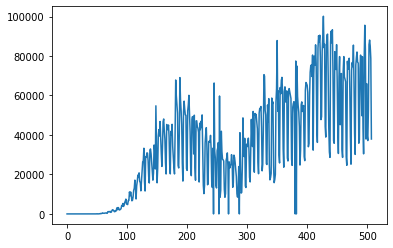

Evolução de mortes confirmadas.


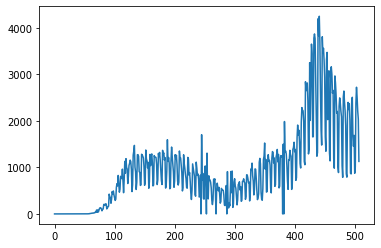

In [ ]:
#SUMÁRIO POR PAÍS
print('Parnorama diário - ' + dados[0][0])
print('Quantidade de casos do dia - '+str(dados[0][5])[:10] +': '+str(dados[0][6]))
print('Quantidade de mortes do dia - '+str(dados[0][5])[:10] +': '+str(dados[0][7]))
print('')

if (numero_destino != ''):
  #Cria sms
  mensagem = 'Parnorama diário - ' + dados[0][0] + ', Quantidade de Casos do dia: '+str(dados[0][6]) + ', Mortes: '+str(dados[0][7]) +' #fiqueEmCasa'
  response = clienteSms.sms.enviar(numero_destino, mensagem)

  #Cria tts
  mensagem = ',Parnorama diário - ' + dados[0][0] + ', Quantidade de casos do dia: '+str(dados[0][6])+ ', Quantidade de mortes do dia: '+str(dados[0][7]) + ', fique em Casa! Vou repetir. Parnorama diário - ' + dados[0][0] + ', Quantidade de casos do dia: '+str(dados[0][6])+ ', Quantidade de mortes do dia: '+str(dados[0][7]) + ', fique em Casa!'
  response = clienteTts.tts.enviar(numero_destino, mensagem)

#Preenche lista para o gráfico de evolução de casos
x = []
for y in dados:
   x.append(y[6])

print('Evolução de casos confirmados.')
fig, ax = plt.subplots()
ax.plot(list(reversed(x)))
plt.show()

#Preenche lista para o gráfico de evolução de mortes
x = []
for y in dados:
   x.append(y[7])

print('Evolução de mortes confirmadas.')
fig, ax = plt.subplots()
ax.plot(list(reversed(x)))
plt.show()

# Final de semana "para" a contagem, por isso tal variação


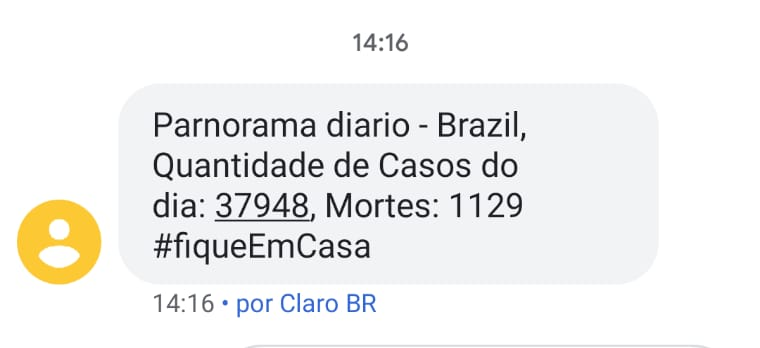

In [ ]:
#CONSULTA 1 e 2
import seaborn as sns

mycursor.execute('''
select co.Country, cd1.Confirmed, cd1.Deaths, cd1.Recovered, cd1.Active, 
(cd1.Confirmed - cd2.Confirmed) as day_confirmed, 
(cd1.Deaths - cd2.Deaths) as day_deaths, 
(cd1.Recovered - cd2.Recovered) as day_recovered, cd1.Date 
from countryData cd1 
left join 
(select CountryCode, Confirmed, Deaths, Recovered, Active, Date from countryData) cd2 
on cd1.CountryCode = cd2.CountryCode and cd1.Date = (cd2.Date + interval 1 DAY) 
left join countries co
on co.ISO2 = cd1.CountryCode
where cd1.CountryCode in 
(select CountryCode from (select CountryCode , max(Confirmed) Confirmed 
from countryData group by CountryCode order by Confirmed Desc limit 1)tab) 
and cd2.CountryCode is not null 
order by cd1.Date desc 
''')

dados = mycursor.fetchall()


Parnorama diário - United States of America
Quantidade de casos do dia (2021-06-13): 4575
Quantidade de mortes do dia (2021-06-13): 105



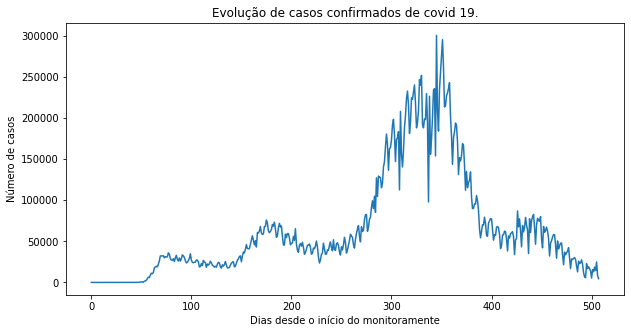

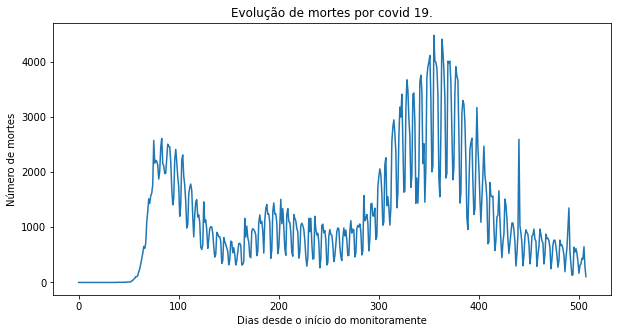

In [ ]:
#Relatório
print('Parnorama diário - ' + dados[0][0])
print('Quantidade de casos do dia ('+str(dados[0][8])[:10]+'): '+str(dados[0][5]))
print('Quantidade de mortes do dia ('+str(dados[0][8])[:10]+'): '+str(dados[0][6]))
print('')

#Preenche lista para o gráfico de evolução de casos
x = []
for y in dados:
   x.append(y[5])

fig, ax = plt.subplots(figsize=(10, 5))

plt.title("Evolução de casos confirmados de covid 19.")
plt.xlabel("Dias desde o início do monitoramente")
plt.ylabel("Número de casos")

ax.plot(list(reversed(x)))
plt.show()

#Preenche lista para o gráfico de evolução de mortes
x = []
for y in dados:
   x.append(y[6])

fig, ax = plt.subplots(figsize=(10, 5))

plt.title("Evolução de mortes por covid 19.")
plt.xlabel("Dias desde o início do monitoramente")
plt.ylabel("Número de mortes")

ax.plot(list(reversed(x)))
plt.show()


In [ ]:
#CONSULTA 3
mycursor.execute('''
select Country, max(Confirmed) Confirmed 
from countryData cd
left join countries co
on co.ISO2 = cd.CountryCode
group by Country 
order by Confirmed Desc limit 10''')
dados = mycursor.fetchall()

Ranking do total de casos confirmados:


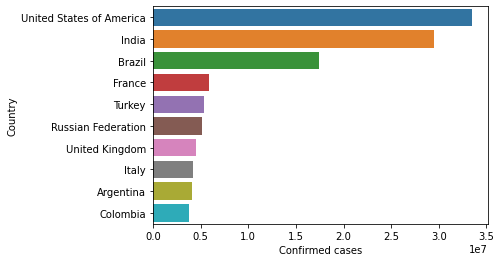

In [ ]:
import pandas as pd
graph = []

print('Ranking do total de casos confirmados:')

for x in dados:
  graph.append([x[0], x[1]])

# Normalizar dados em relação a população

df = pd.DataFrame(data=graph)
df.columns = ["Country", "Confirmed cases"]
sns.barplot(data=df, x="Confirmed cases", y="Country") #, color="blue")


In [ ]:
#CONSULTA 4
mycursor.execute('''
select Country, max(Deaths) Deaths 
from countryData cd
left join countries co
on co.ISO2 = cd.CountryCode
group by Country 
order by Deaths Desc limit 10''')
dados = mycursor.fetchall()

Ranking do total de mortes:


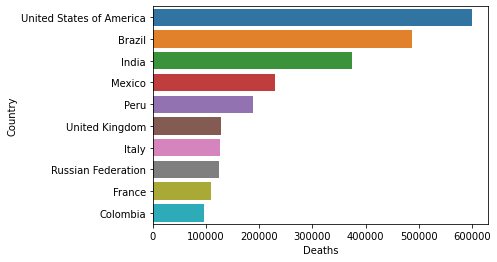

In [ ]:
graph = []

print('Ranking do total de mortes:')

for x in dados:
    graph.append([x[0], x[1]])
  
# Normalizar dados em relação a população

df = pd.DataFrame(data=graph)
df.columns = ["Country", "Deaths"]
sns.barplot(data=df, x="Deaths", y="Country") #, color="blue")

In [ ]:
con.close() #Fecha conexão com o banco

NameError: ignored